In [39]:
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

plt.ion() 
plt.gray()

<Figure size 640x480 with 0 Axes>

In [40]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")

MPS found


## Parameters

In [41]:
# Parameters 

# criterion = nn.BCELoss()
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# criterion = nn.MultiLabelSoftMarginLoss()


# optimizer = optim.SGD(net.parameters(), lr=0.0006, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 100
batch_size = 128 #how many units in each insert in the pipeline

activation_func = F.relu
# activation_func = F.sigmoid

## MODEL 

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
    # output size = 6 *44*44 values 
    # image size : n*n 
    # filter size: f*f (f is odd number)
    # shrinked_image size : (n - f + 1)^2 

        self.pool = nn.MaxPool2d(2, 2)
    # default stride is 2 because it was not specified so defaults to kernel size which is 2
    # output size = ((n-f+1)/2)^2 = 22*22 *6  
        
        self.conv2 = nn.Conv2d(6, 16, 5)
     #output size = 18 * 18 * 16 = 5184   
        
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(activation_func(self.conv1(x))) 
        # 44*44*6 , 22*22*6 
        
        x = self.pool(activation_func(self.conv2(x)))
        # 18*18*16 , 9*9*16 
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = activation_func(self.fc1(x))
        x = activation_func(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [43]:
# optimizer = optim.SGD(net.parameters(), lr=0.0006, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# scheduler 

In [44]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [45]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        image = io.imread(img_name)
        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        if self.transform:
            sample = self.transform(sample)

        return sample #return a transformed image with label

In [46]:
#     class to transform to a normalized tensor (only the image pixel value is transformed)
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, emotions = sample['image'], sample['emotions']
        transform = transforms.ToTensor()

        return {'image': transform(image),
                'emotions': emotions}

In [47]:
train_dataset = FERPlusDataset(os.path.join(train_folder_path,"label.csv"), train_folder_path, transform=ToTensor())
valid_dataset = FERPlusDataset(os.path.join(valid_folder_path, "label.csv"), valid_folder_path, transform=ToTensor())
test_dataset = FERPlusDataset(os.path.join(test_folder_path, "label.csv"), test_folder_path, transform=ToTensor())

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [48]:
# # JUST FOR DEBUGGING 
# np_img = train_dataset[7]['image']
# plt.imshow(np.transpose(np_img, (1, 2, 0)))
# plt.show()

# for i_batch, sample_batched in enumerate(trainloader):
    # print(i_batch, sample_batched['image'].size(),
    #       sample_batched['emotions'].size())

    # # observe 4th batch and stop.
    # if i_batch == 3:
    #     print(sample_batched)
    #     break

Epoch 1/100:
Training Loss: 18.0381 | Training Accuracy: 10.86%
Validation Loss: 16.5122 | Validation Accuracy: 14.65%
-----------------------------------
Epoch 2/100:
Training Loss: 15.9856 | Training Accuracy: 24.46%
Validation Loss: 15.6242 | Validation Accuracy: 19.26%
-----------------------------------
Epoch 3/100:
Training Loss: 15.0391 | Training Accuracy: 27.46%
Validation Loss: 14.4915 | Validation Accuracy: 31.16%
-----------------------------------
Epoch 4/100:
Training Loss: 14.4031 | Training Accuracy: 30.16%
Validation Loss: 14.0254 | Validation Accuracy: 31.69%
-----------------------------------
Epoch 5/100:
Training Loss: 13.9590 | Training Accuracy: 32.03%
Validation Loss: 13.5913 | Validation Accuracy: 33.37%
-----------------------------------
Epoch 6/100:
Training Loss: 13.6103 | Training Accuracy: 33.54%
Validation Loss: 13.2066 | Validation Accuracy: 32.48%
-----------------------------------
Epoch 7/100:
Training Loss: 13.2950 | Training Accuracy: 35.04%
Valida

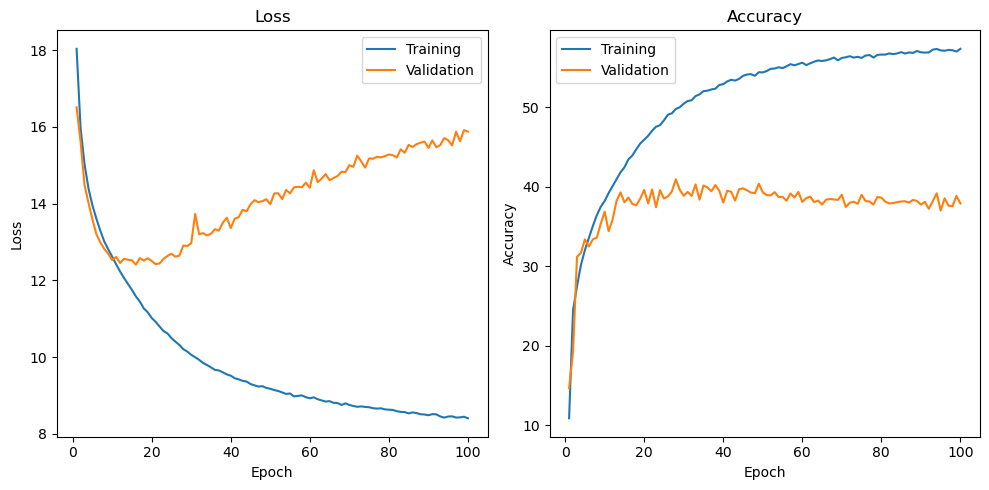

In [49]:
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

st = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        
        labels = data['emotions'].to(device)
        inputs = data['image'].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print("label before: ", labels)
        # print("predicted before: ", outputs)
        # Calculate and store training accuracy
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        
        # print("label: ", labels)
        # print("predicted: ", predicted)
        # print("pred size: " , predicted.shape)
        total += labels.size(0)
        correct += (labels.bool() & (predicted == labels)).sum().item()
        # print("1 more correct..")
    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)
    
    # Perform validation
    net.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for data in validloader:
            labels = data['emotions'].to(device)
            images = data['image'].to(device)
            
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            
            total += labels.size(0)
            # print("total: " , total)
            correct += (labels.bool() & (predicted == labels)).sum().item()
    
    net.train()
    
    valid_loss.append(running_loss / len(validloader))
    valid_accuracy.append(100 * correct / total)
    
    # Print the training and validation loss and accuracy
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Training Loss: {train_loss[-1]:.4f} | Training Accuracy: {train_accuracy[-1]:.2f}%')
    print(f'Validation Loss: {valid_loss[-1]:.4f} | Validation Accuracy: {valid_accuracy[-1]:.2f}%')
    print('-----------------------------------')

elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Finished Training')

# Plotting the loss and accuracy
plt.figure(figsize=(10, 5))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='Training')
plt.plot(range(1, epochs+1), valid_loss, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Training')
plt.plot(range(1, epochs+1), valid_accuracy, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()